In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import sys
sys.path.insert(0,'../code/functions/')
import neuroGraphLib as ngLib
import tiffIO as tIO
import cv2
from random import randrange as rand
import scipy.ndimage as ndimage
import plotly
plotly.offline.init_notebook_mode()
from IPython.display import IFrame
%matplotlib inline
import matplotlib.pyplot as plt
import pylab

The purpose of Adaptive Thresholding is to identify synapses given a raw image.

# 1. Pseudocode

In [2]:
IFrame("AdaptivePseudocode.pdf", width=600, height=600)

# 2. Actual Code

In [74]:
def adaptiveThreshold(inImg, sx, sy):
    outImg = np.zeros_like(inImg)
    shape = outImg.shape
    sz = shape[0]
    subzLen = shape[0]/sz
    subYLen = shape[1]/sy
    subxLen = shape[2]/sx
    averages = []
    for zInc in range(1, sz + 1):
        for yInc in range(1, sy + 1):
            for xInc in range(1, sx + 1):
                sub = inImg[(zInc-1)*subzLen: zInc*subzLen, (yInc-1)*subYLen: yInc*subYLen, (xInc-1)*subxLen: xInc*subxLen]
                averages.append(np.mean(sub))
    mean = np.mean(averages)
    std = np.std(averages)
    for zInc in range(1, sz + 1):
        for yInc in range(1, sy + 1):
            for xInc in range(1, sx + 1):
                sub = inImg[(zInc-1)*subzLen: zInc*subzLen, (yInc-1)*subYLen: yInc*subYLen, (xInc-1)*subxLen: xInc*subxLen]
                percentile = 85 - 20 * (np.mean(sub) - mean)/std
                if percentile > 100:
                    percentile = 100
                if percentile < 0:
                    percentile = 0
                subThresh = binaryThreshold(sub, percentile)
                outImg[(zInc-1)*subzLen: zInc*subzLen, (yInc-1)*subYLen: yInc*subYLen, (xInc-1)*subxLen: xInc*subxLen] = subThresh
    return outImg/256

def binaryThreshold(img, percentile=80):
    img = (256*img).astype('uint8')
    threshImg = np.zeros_like(img)
    percentile = np.percentile(img, percentile)
    for i in range(len(img)):
        threshImg[i] = cv2.threshold(img[i], percentile, 255, cv2.THRESH_TOZERO)[1]
    return threshImg



# 3. Predicted Performance Conditions
I believe that Adaptive Thresholding will perform well under the condition that there is a large difference between the pixel intensity of surrounding background pixels and the target pixels.

# 4. Simulation Data

## Easy Sim 
The sim data has very clearly separated foreground and background with the background increasing uniformly.

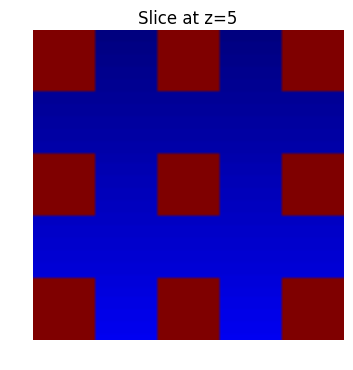

In [95]:
simEasyGrid = np.zeros((100, 100, 100))

for i in range(100):
    for j in range(100):
        for k in range(100):
            simEasyGrid[i][j][k] = j
            
for i in range(4):
    for j in range(4):
        for k in range(4):
            simEasyGrid[20*(2*j): 20*(2*j + 1), 20*(2*i): 20*(2*i + 1), 20*(2*k): 20*(2*k + 1)] = 1000
            
plt.imshow(simEasyGrid[5])
plt.axis('off')
plt.title('Slice at z=5')
plt.show()

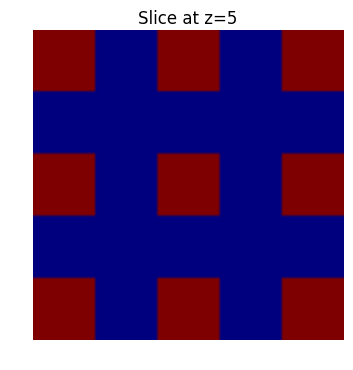

In [102]:
afterThresh = adaptiveThreshold(simEasyGrid[5:6], 1, 1)
plt.imshow(afterThresh[0])
plt.axis('off')
plt.title('Slice at z=5')
plt.show()

## Easy Sim Analysis 
As you can see above, Adaptive Thresholding clearly identifies foreground from varying background effectively. 

## Realistic Sim 
The realistic simulation will be run on data that models the distribution of synapses and noise in our true data.

In [15]:
def generatePointSet():
    center = (rand(0, 9), rand(0, 999), rand(0, 999))
    toPopulate = []
    for z in range(-3, 2):
        for y in range(-3, 2):
            for x in range(-3, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 1000:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((10, 1000, 1000))
    myPointSet = set()
    for _ in range(rand(1000, 2000)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = rand(40000, 60000)
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    toPop = rand(0, 10)
                    if toPop == 5:
                        noiseVolume[z][y][x] = rand(0, 60000)
    return volume, noiseVolume

def generateDenseVolume(n):
    #create a test volume
    volume = np.zeros((10, 1000, 1000))
    myPointSet = set()
    for _ in range(n):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = rand(40000, 60000)
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    toPop = rand(0, 10)
                    if toPop == 5:
                        noiseVolume[z][y][x] = rand(0, 60000)
    return volume, noiseVolume

def applyGradient(volume, originX, originY):
    outStack = []
    maxDistance = np.sqrt((volume[0].shape[0])**2+(volume[0].shape[1])**2)
    for sample in volume:
        outSample = np.zeros_like(sample)
        for y in range(sample.shape[0]):
            for x in range(sample.shape[1]):
                distance = np.sqrt((x - originX)**2+(y - originY)**2)
                sigma = np.sqrt(distance)/np.sqrt(maxDistance)
                modifier = 1.-(sigma * distance/maxDistance)
                outSample[y][x] = modifier * sample[y][x]
        outStack.append(outSample)
    return np.stack(outStack)

## Scoring Code
The following code was lifted from the precisionrecall notebook and calculates f1 score, among other stats

In [33]:
def precision_recall_f1(labels, predictions, overlapRatio=1):
   

    if len(predictions) == 0:
        print 'ERROR: prediction list is empty'
        return 0., 0., 0.
    
    labelFound = np.zeros(len(labels))
    truePositives = 0
    falsePositives = 0

    for prediction in predictions:
        #casting to set is ok here since members are uinque
        predictedMembers = set([tuple(elem) for elem in prediction.getMembers()])
        detectionCutoff = overlapRatio * len(predictedMembers)
        found = False
        
        for idx, label in enumerate(labels):
            labelMembers = set([tuple(elem) for elem in label.getMembers()])
            #if the predictedOverlap is over the detectionCutoff ratio
            if len(predictedMembers & labelMembers) >= detectionCutoff:
                truePositives +=1
                found=True
                labelFound[idx] = 1
        
        if not found:
            falsePositives +=1
            
    precision = truePositives/float(truePositives + falsePositives)
    recall = np.count_nonzero(labelFound)/float(len(labels))
    f1 = 0
    try:
        f1 = 2 * (precision*recall)/(precision + recall)
        
    except ZeroDivisionError:
        f1 = 0
        
    return precision, recall, f1

In [230]:
#running test on wills version of thresholding, maybe there is a way to either boost his implementation or combine it with mine to form a better filter
testGenVolLabel, testGenVol = generateTestVolume()

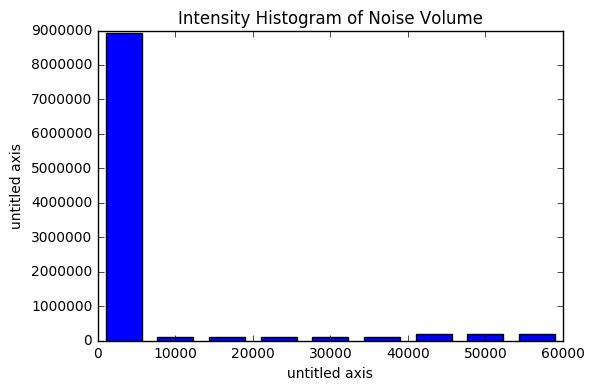

In [233]:
mv.generateVoxHist(noiseVol, figName="Intensity Histogram of Noise Volume", bins=9) 

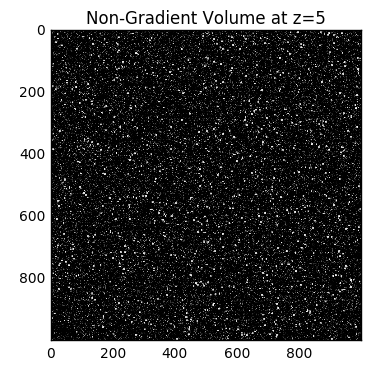

In [232]:
plt.figure()
plt.title('Non-Gradient Volume at z=5')
plt.imshow(testGenVol[5], cmap='gray')
plt.show()

In [234]:
testGenVolGrad = applyGradient(testGenVol, 0, 0)

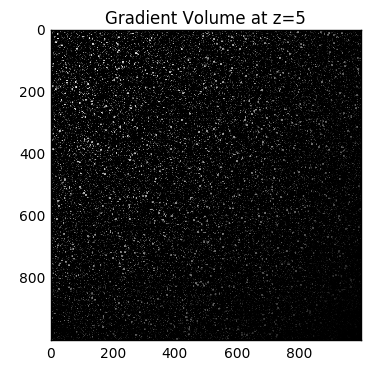

In [235]:
plt.figure()
plt.title('Gradient Volume at z=5')
plt.imshow(testGenVolGrad[5], cmap='gray')
plt.show()

# Simulations

In [22]:
testVol, noiseVol = generateTestVolume()

In [27]:
noiseVolGrad = applyGradient(noiseVol, 0, 0)

In [30]:
testAdaptive = adaptiveThreshold(noiseVol, 64, 64)
testGrad = adaptiveThreshold(noiseVolGrad, 64, 64)

## Base

In [31]:
clustersT1 = clusterThresh(testVol[4:6])
clustersA = clusterThresh(testAdaptive[4:6])

In [35]:
clustersG = clusterThresh(testGrad[4:6])

In [36]:
precisionA, recallA, f1A = precision_recall_f1(clustersT1, clustersG)

In [328]:
print 'Base:'
print '\tPrecision: ', precisionA
print '\tRecall: ', recallA
print '\tf1: ', f1A

Base:
	Precision:  1.0
	Recall:  0.954385964912
	f1:  0.976660682226


## Gradient

In [294]:
clustersG = clusterThresh(testGrad[4:6])
precisionG, recallG, f1G, _, _, _ = f1score(clustersT1, clustersG)
print 'Gradient:'
print '\tPrecision: ', precisionG
print '\tRecall: ', recallG
print '\tf1: ', f1G

Gradient:
	Precision:  1.0
	Recall:  0.954385964912
	f1:  0.976660682226


# Conclusion From Simulations
The results from Adaptive Threshold were extremely good. The F1 score had an average of .976, and was the same as the base model. This means that adaptive threshold successfuly filters our gradients, as are present in many two-fluorescent images.

In [4]:
tp2 = tIO.loadTiff('../../data/newData/rr46b_s0_ch1.tif')[13:16]
tp3 = tIO.loadTiff('../../data/newData/rr46b_s1_ch1.tif')

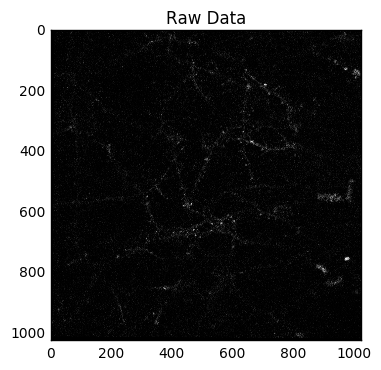

In [75]:
plt.imshow(tp2[2], cmap='gray')
plt.title("Raw Data")
plt.show()

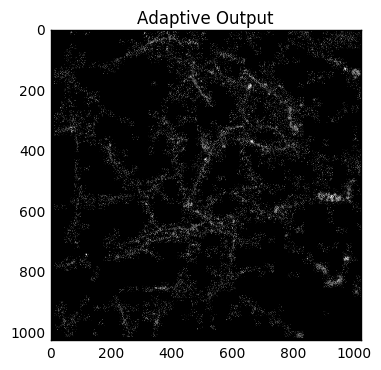

In [76]:
dendrites, _ = ngLib.boostDendrites(tp2, percentile = 50)
adaptive = adaptiveThreshold(dendrites, 32, 32)
plt.imshow(adaptive[1], cmap='gray')
plt.title('Adaptive Output')
plt.show()

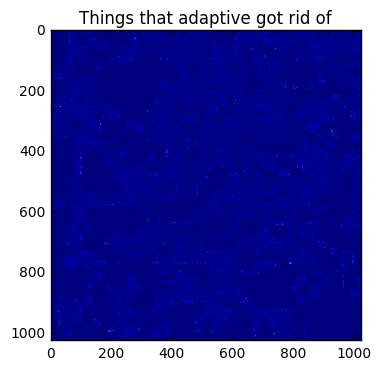

In [77]:
diff = dendrites - adaptive
plt.imshow(diff[2])
plt.title("Things that adaptive got rid of")
plt.show()

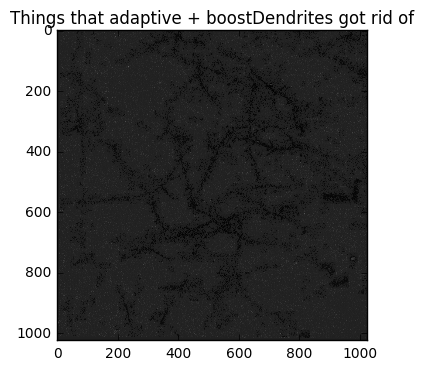

In [78]:
diff2 = tp2/np.mean(tp2) - adaptive/np.mean(adaptive)
plt.imshow(diff2[2], cmap='gray')
plt.title("Things that adaptive + boostDendrites got rid of")
plt.show()

# Final Conslusion 
Adaptive Thresholding works extremely well. It gives us all of the statistics we like. I am happy :)